In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

import sys

sys.path.append('../../helper_classes')
from limit_utils import get_sensitivity_bands

2025-04-02 22:53:11.720458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743659591.749483 1578469 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743659591.755788 1578469 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743659591.770678 1578469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743659591.770691 1578469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743659591.770694 1578469 computation_placer.cc:177] computation placer alr

In [2]:
def get_signal_rates_from_likelihood(likelihood_file):
    sys.path.append('..')
    likelihood_class = __import__('create_simple_template_likelihood', globals(), locals(), [])
    class_names = [name for name in dir(likelihood_class) if isinstance(getattr(likelihood_class, name), type)]
    globals().update({name: getattr(likelihood_class, name) for name in class_names})
    
    likelihood_container = pkl.load(open(likelihood_file, 'rb'))
    signal_expected_mean = likelihood_container.expected_signal_counts
    
    return signal_expected_mean

In [3]:
def scaling_fn(mu, mu_ref):
    return mu / mu_ref * 1e-45

In [4]:
signal_expected_mean = get_signal_rates_from_likelihood('../wimp_sensitivity/likelihoods/SI_60t_benchmark.pkl')

In [5]:
masses, bands = get_sensitivity_bands(directory='../wimp_sensitivity/outputs/SI_60t_benchmark',
                                      scaling_fn=scaling_fn,
                                      signal_name='WIMP',
                                      signal_expected_mean=signal_expected_mean,
                                      inference_config='../wimp_sensitivity/inference_configs/SI_WIMP_benchmark.ini')

Found 162 failed toy for WIMP65; removing...
Found 260 failed toy for WIMP5000; removing...


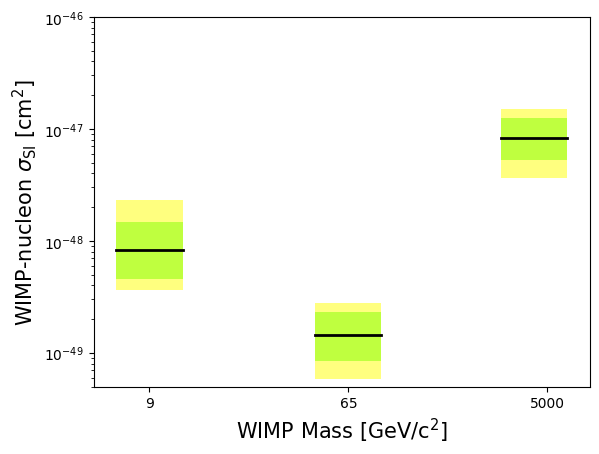

In [6]:
fig = plt.figure()
ax = fig.gca()
delta = 0.05

ticks_plot = {0.2: 0,
              0.5: 1,
              0.78: 2}
for tick, i in ticks_plot.items():

    plt.plot([tick-delta, tick+delta],
             2*[bands[0][i]],
             color='k', linewidth=2)
    plt.fill_between([tick-delta, tick+delta],
                     2*[bands[-1][i]], 2*[bands[1][i]],
                     facecolor='#00ff00', alpha=0.5)
    plt.fill_between([tick-delta, tick+delta],
                     2*[bands[-2][i]], 2*[bands[2][i]],
                     facecolor='#ffff00', alpha=0.5)

xlab = r'WIMP Mass [GeV/c$^2$]'
ax.set_xlabel(xlab, fontsize=15)
plt.xticks([0.2, 0.5, 0.8], labels=[9, 65, 5000])

ylab = r'WIMP-nucleon $\sigma_{\rm SI}$ [cm$^2$]'
ylim = (5e-50, 1e-46)
ax.set_ylabel(ylab, fontsize=15)
ax.set_ylim(ylim)

ax.set_yscale('log')